# Self-Driving Car Engineer Nanodegree


**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Import Packages

In [1]:
#importing packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import cv2
import glob
import pickle
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

%matplotlib inline

## Training Data

# of vehicle images:  8792
# of non-vehicle images:  8968


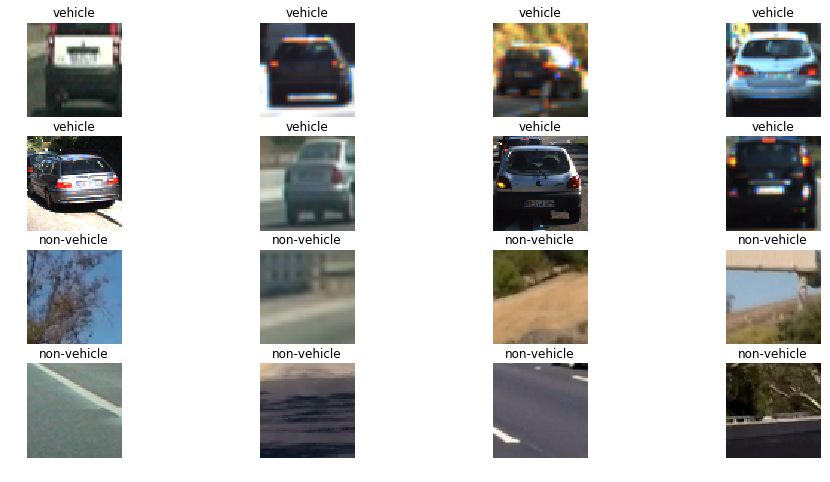

In [2]:
vehicles = glob.glob('data/vehicles/vehicles/**/*.png')
non_vehicles = glob.glob('data/non-vehicles/non-vehicles/**/*.png')

# Visualize Dataset.
fig, ax = plt.subplots(4,4, figsize=(16, 8))
ax = ax.ravel()

# Plot the images from Vehicle class
for i in np.arange(8):
    img = cv2.imread(vehicles[np.random.randint(0,len(vehicles))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    ax[i].axis('off')
    ax[i].set_title('vehicle')
    ax[i].imshow(img)

# Plot the images from Not Vehicle class
for i in np.arange(8,16):
    img = cv2.imread(non_vehicles[np.random.randint(0,len(non_vehicles))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    ax[i].axis('off')
    ax[i].set_title('non-vehicle')
    ax[i].imshow(img)
    
print('# of vehicle images: ', len(vehicles))
print('# of non-vehicle images: ', len(non_vehicles))

## Histogram of Oriented Gradients (HOG)

#### Functions

In [3]:
# Function to return HOG features.
# This code is from the lectures.
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.features.hog() function to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:
        # Use skimage.features.hog() function to get features only
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# This code is from the lectures.
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features    
    
# Define a function to compute color histogram features.
# This code is from the lectures.
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
    
# Function to extract features from a list of images
# This code is from lectures.
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in images one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        spatial_features = bin_spatial(feature_image)
        file_features.append(spatial_features)            
        hist_features = color_hist(feature_image)
        file_features.append(hist_features)
        
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new features vector to the features list
        file_features.append(hog_features)
        
        features.append(np.concatenate(file_features))    
        
    # Return list of features vectors
    return features

#### Visualize

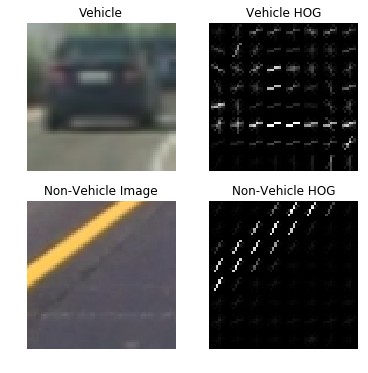

In [4]:
# Visualize HOG
# Read the images
img_vehicle = mpimg.imread(vehicles[np.random.randint(0,len(vehicles))])
img_notvehicle = mpimg.imread(non_vehicles[np.random.randint(0,len(vehicles))])
# Call get_hog_features() function with tuned parameters and vis enabled and plot the hog image.
car_feat, car_hog = get_hog_features(img_vehicle[:,:,0], 9, 8, 2, vis=True, feature_vec=True)
notcar_feat, notcar_hog = get_hog_features(img_notvehicle[:,:,0], 9, 8, 2, vis=True, feature_vec=True)

# Plot the Images
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(6,6))
ax1.imshow(img_vehicle)
ax1.set_title('Vehicle')
ax1.axis('off')
ax2.imshow(car_hog, cmap='gray')
ax2.set_title('Vehicle HOG')
ax2.axis('off')
ax3.imshow(img_notvehicle)
ax3.set_title('Non-Vehicle Image')
ax3.axis('off')
ax4.imshow(notcar_hog, cmap='gray')
ax4.set_title('Non-Vehicle HOG')
ax4.axis('off')
plt.show()

#### Train Classifier

In [5]:
# Parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
colorspace = 'YCrCb' # pick from RGB, HSV, LUV, HLS, YUV, YCrCb
hog_channel = 'ALL' # pick from 0, 1, 2, or "ALL"

# Vehicle features
vehicle_features = extract_features(vehicles, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
# Non-Vehicle features
non_vehicle_features = extract_features(non_vehicles, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

# Create an array stack of feature vectors
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)  
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

# Split data
random_set = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=random_set)

print('Orientations:', orient, '\nPixels per cell:', pix_per_cell, '\nCells per block:', cell_per_block, '\nFeature array length:', len(X_train[0]))

# Linear SVC
svc = LinearSVC()
# Train
svc.fit(X_train, y_train)
# Accuracy
print('Test Accuracy of SVC: ', round(svc.score(X_test, y_test), 4))

Orientations: 9 
Pixels per cell: 8 
Cells per block: 2 
Feature array length: 8460
Test Accuracy of SVC:  0.989


## Sliding Window Search

#### Functions

In [6]:

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    boxes = []
    
    img_tosearch = img[ystart:ystop,:,:]
    
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = pix_per_cell * pix_per_cell
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg)
            hist_features = color_hist(subimg)

            # Scale features and make a prediction            
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
                     
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
               # cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return draw_img, boxes

# Define a function to draw bounding boxes.  Added random color for visaulization
# This code is from lectures.
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


#### Parameters

In [7]:
colorspace = 'YCrCb' # pick from RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
thresh = 2
hog_channel = 'ALL' # pick from 0, 1, 2, or "ALL"

#### Search areas

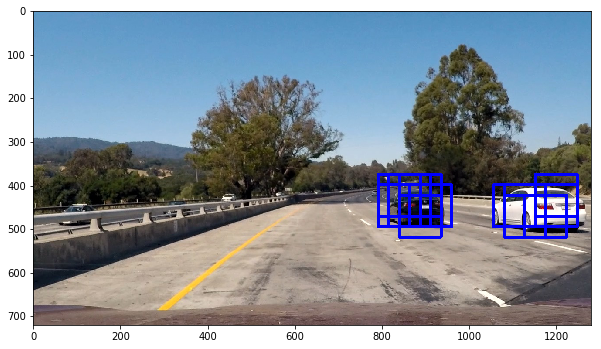

In [8]:
ystart = 350
ystop = 650
scale = 1.5

#Example Sliding Window
img_test1 = mpimg.imread('test_images/test1.jpg')
out_img1, boxes = find_cars(img_test1, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)
#out_img_draw1 = draw_labeled_bboxes(out_img1, boxes)
#img_test2 = mpimg.imread('test_images/test3.jpg')
#out_img2, boxes = find_cars(img_test2, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)
#out_img_draw2 = draw_labeled_bboxes(out_img2, boxes)

plt.figure(figsize=(10,10))
plt.imshow(out_img1)

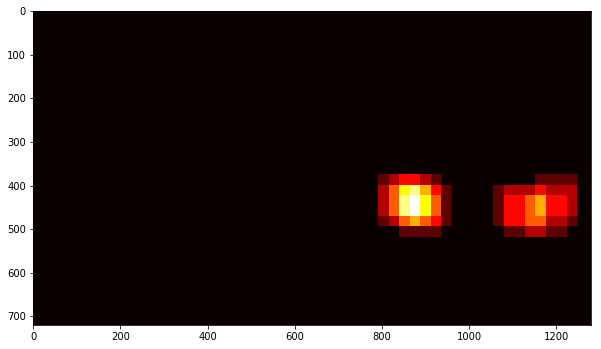

In [10]:
img_heat = np.zeros_like(img_test1[:,:,0])
img_heat = add_heat(img_heat, boxes)
plt.figure(figsize=(10,10))
plt.imshow(img_heat, cmap='hot')
plt.show()

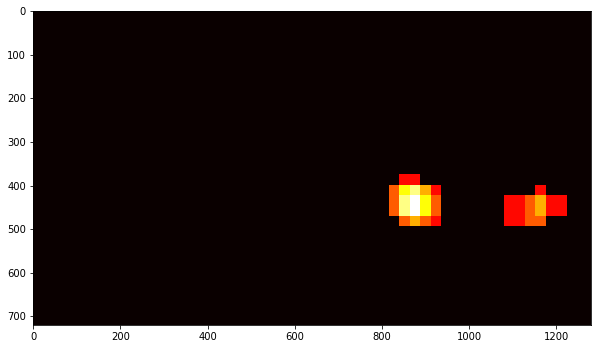

In [11]:
img_heat = apply_threshold(img_heat, thresh)
plt.figure(figsize=(10,10))
plt.imshow(img_heat, cmap='hot')
plt.show()

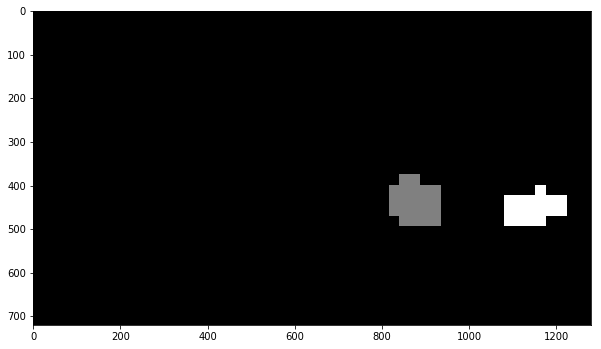

In [12]:
labels = label(img_heat)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')

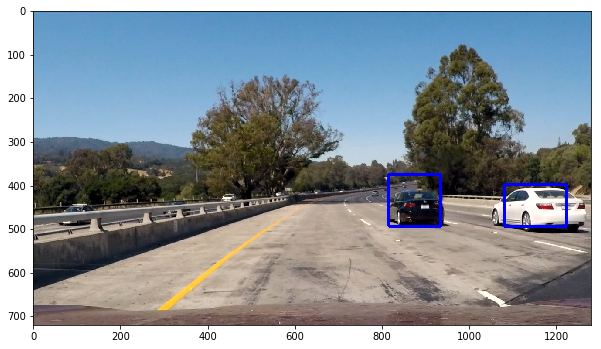

In [14]:
draw_img = draw_labeled_bboxes(np.copy(img_test1), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)
plt.show()

In [15]:

def find_cars_pipeline(img, threshold = 2, heatmap_vis = False):
    labels = []
    #using 3 scales to find cars
    scales = [1.0, 1.5, 2.0, 2.5, 3.0]
    for scale in scales:
        out_img,box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    
        # Add heat to each box in box list
        find_cars_pipeline.heat = add_heat(find_cars_pipeline.heat,box_list)

    # Apply threshold to help remove false positives
    find_cars_pipeline.heat = apply_threshold(find_cars_pipeline.heat,threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(find_cars_pipeline.heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    # Guide the next detection
    find_cars_pipeline.heat = np.zeros_like(img[:,:,0]).astype(np.float)
    find_cars_pipeline.heat[labels[0].nonzero()] = 1
    if heatmap_vis:
        return draw_img, heatmap, labels[0]
    else:
        return draw_img

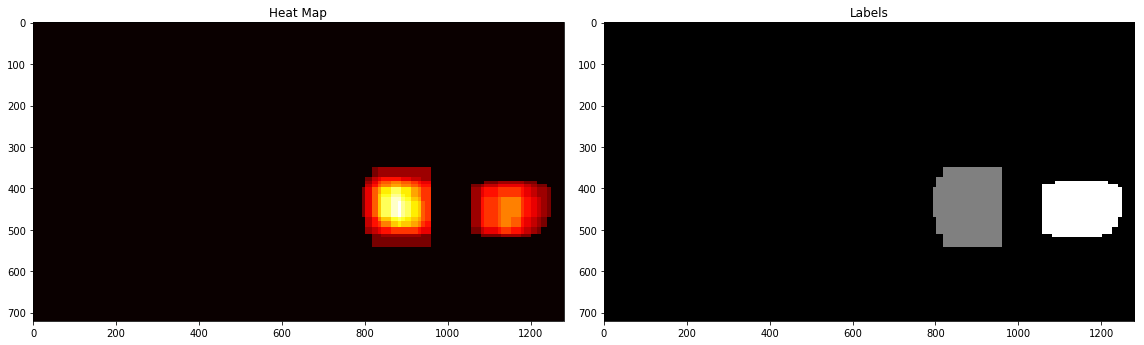

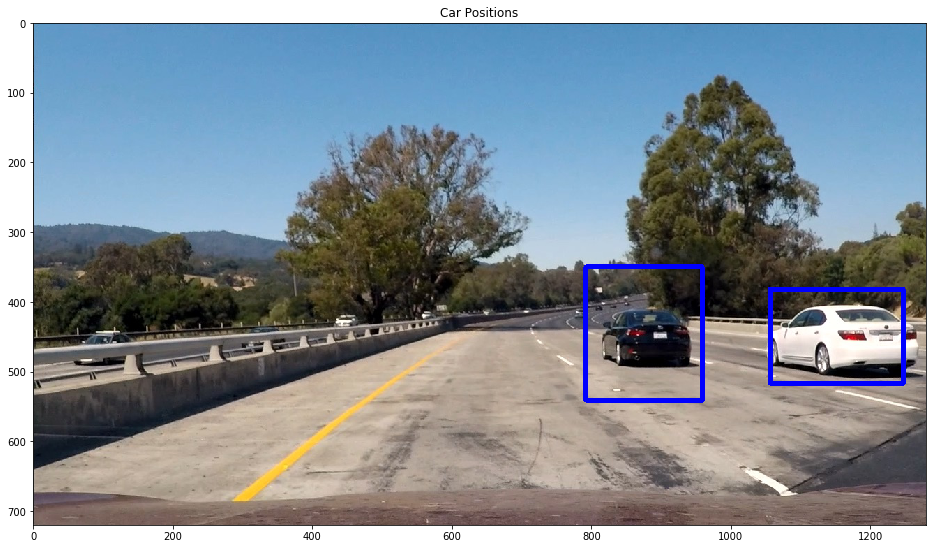

In [16]:
img = mpimg.imread('test_images/test1.jpg')

find_cars_pipeline.heat = np.zeros_like(img[:,:,0]).astype(np.float)
d_img, heatmap, lbls = find_cars_pipeline(img, thresh, heatmap_vis=True)

fig = plt.figure(figsize=(16,16))
plt.subplot(121)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.subplot(122)
plt.imshow(lbls,cmap='gray')
plt.title('Labels')
fig.tight_layout()
fig = plt.figure(figsize=(16,16))
plt.imshow(d_img)
plt.title('Car Positions')
tmp = cv2.cvtColor(d_img,cv2.COLOR_RGB2BGR)
# cv2.imwrite('output_images/test6.jpg',tmp)

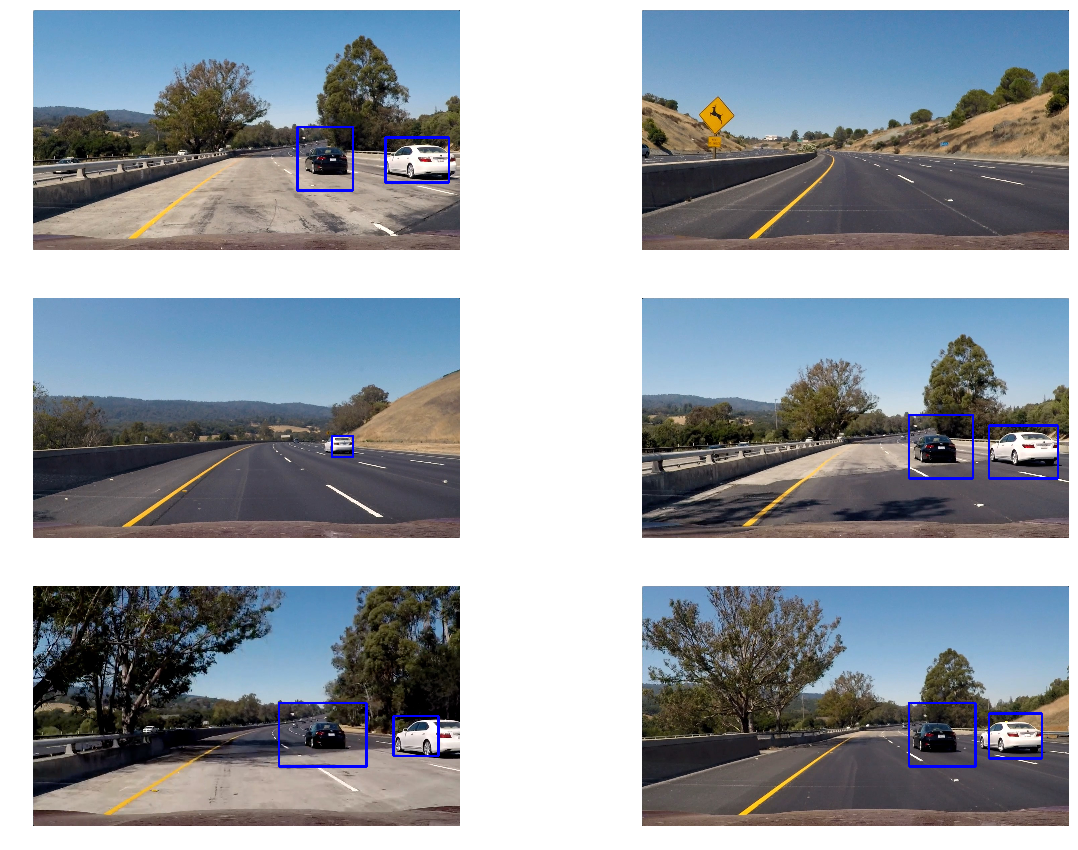

In [17]:
img1 = mpimg.imread('test_images/test1.jpg')
img2 = mpimg.imread('test_images/test2.jpg')
img3 = mpimg.imread('test_images/test3.jpg')
img4 = mpimg.imread('test_images/test4.jpg')
img5 = mpimg.imread('test_images/test5.jpg')
img6 = mpimg.imread('test_images/test6.jpg')

fig, vaxis = plt.subplots(3, 2, figsize=(20,15))
vaxis = vaxis.ravel()
find_cars_pipeline.heat = np.zeros_like(img1[:,:,0]).astype(np.float)
d_img1, heatmap1, lbls1 = find_cars_pipeline(img1, thresh, heatmap_vis=True)
vaxis[0].axis('off')
vaxis[0].imshow(d_img1)

find_cars_pipeline.heat = np.zeros_like(img2[:,:,0]).astype(np.float)
d_img2, heatmap2, lbls2 = find_cars_pipeline(img2, thresh, heatmap_vis=True)
vaxis[1].axis('off')
vaxis[1].imshow(d_img2)

find_cars_pipeline.heat = np.zeros_like(img3[:,:,0]).astype(np.float)
d_img3, heatmap3, lbls3 = find_cars_pipeline(img3, thresh, heatmap_vis=True)
vaxis[2].axis('off')
vaxis[2].imshow(d_img3)

find_cars_pipeline.heat = np.zeros_like(img4[:,:,0]).astype(np.float)
d_img4, heatmap4, lbls4 = find_cars_pipeline(img4, thresh, heatmap_vis=True)
vaxis[3].axis('off')
vaxis[3].imshow(d_img4)

find_cars_pipeline.heat = np.zeros_like(img5[:,:,0]).astype(np.float)
d_img5, heatmap5, lbls5 = find_cars_pipeline(img5, thresh, heatmap_vis=True)
vaxis[4].axis('off')
vaxis[4].imshow(d_img5)

find_cars_pipeline.heat = np.zeros_like(img6[:,:,0]).astype(np.float)
d_img6, heatmap6, lbls6 = find_cars_pipeline(img6, thresh, heatmap_vis=True)
vaxis[5].axis('off')
vaxis[5].imshow(d_img6)

## Video Implementation

In [18]:
find_cars_pipeline.heat = np.zeros_like(img[:,:,0]).astype(np.float)
test_output = 'test_video_out.mp4'
clip1 = VideoFileClip("test_video.mp4")
test_clip = clip1.fl_image(find_cars_pipeline) #NOTE: this function expects color images!!
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [01:09<00:01,  1.80s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 1min 10s


In [19]:
find_cars_pipeline.heat = np.zeros_like(img[:,:,0]).astype(np.float)
test_output = 'project_video_out.mp4'
clip2 = VideoFileClip("project_video.mp4")
test_clip = clip2.fl_image(find_cars_pipeline) #NOTE: this function expects color images!!
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [38:29<00:01,  1.81s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 38min 30s
